# TSP problem

**See [the other notebook](Guessing_colourmaps.ipynb) for the grisly details and dead-ends.** 

Requirements:

- `numpy`
- `scipy`
- `scikit-learn`

I recommend installing them with `conda install`. 

In [106]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pyplot import imread

In [291]:
from scipy import signal

In [292]:
nx, ny = 100, 100
z = np.random.rand(nx, ny)

sizex, sizey = 30, 30
x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
f = g/g.sum()

z = signal.convolve(z, f, mode='valid')
z = (z - z.min())/(z.max() - z.min())

In [293]:
cd /home/matt/Dropbox/dev/notebooks

/home/matt/Dropbox/dev/notebooks


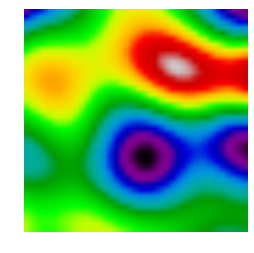

In [294]:
# Note: interpolation introduces new colours.
plt.imshow(z, cmap="spectral")
#plt.imshow(z, cmap="spectral", interpolation='none')

plt.axis('off')
plt.savefig('data/cbar/test.png', bbox_inches='tight')
plt.show()

## Read an image

In [295]:
cd /home/matt/Dropbox/dev/notebooks

/home/matt/Dropbox/dev/notebooks


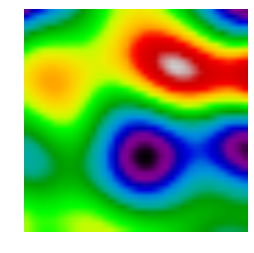

In [296]:
from PIL import Image
img = Image.open('data/cbar/test.png')
#img = Image.open('data/cbar/redblu.png')
img

## Quantize with scikit

In [317]:
n_colours = 128

In [318]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [319]:
im = np.asarray(img) / 255
h, w, d = im.shape
im_ = im.reshape((w * h, d))[:, :3]
sample = shuffle(im_, random_state=0)[:2000]  # Defines training set size

Train:

In [320]:
kmeans = KMeans(n_clusters=n_colours, random_state=0).fit(sample)

Now I can make an RGB palette `p` — also known as a codebook in information theory terms:

In [321]:
p = kmeans.cluster_centers_

# I don't know why I need to do this, but I do. Floating point precision maybe.
p[p > 1] = 1
p[p < 0] = 0

The only problem with this `p` is that it is not in order — that it, there cluster centres are more or less randomly arranged. We will fix that in the next section.

The vector `p` is actually all we need, but if you want to see what the quantized image looks like, carry on:

## Travelling salesman problem

Remember that these points are essentially in random order:

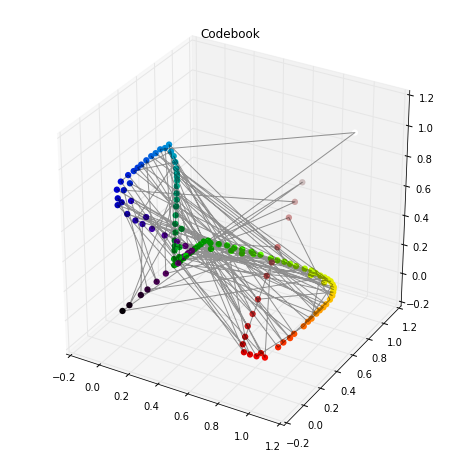

In [322]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*p.T, c=p, lw=0, s=40, alpha=1)
ax.plot(*p.T, color='k', alpha=0.4)
ax.set_title('Codebook')

plt.show()

I propose starting at the dark end (the end of the line nearest black) and crawling aling the line of points from there. This will make a nice organized sequence of codes — in our case, this will be the colourmap.

We can solve this problem as the travelling salesman problem. Find the shortest tour from black to 'the other end'.

To start with, we need the distances between all points. This is just a norm, but there's a convenient function `scipy.spatial.pdist` for finding distance pairs in *n*-space. Then `squareform` casts it into a square symmetric matrix, which is what we need for our TSP solver.

Other than creating a naive TSP solver in Python – let's face it, it'll be broken or slow or non-optimal — there are three good TSP solver options:

* [LKH](http://www.akira.ruc.dk/~keld/research/LKH/) — [parameter help here](http://webhotel4.ruc.dk/~keld/research/LKH/LKH-2.0/DOC/LKH-2.0_PARAMETERS.pdf).
* [Concorde](http://www.math.uwaterloo.ca/tsp/concorde.html) (I followed [these instructions](http://davidsjohnson.net/TSPcourse/mac-install-concorde.txt) for installing concorde on my Mac.)
* [O-R tools](https://developers.google.com/optimization/routing/tsp)

LKH and Concorde can be used via [the TSP Python package](https://github.com/perrygeo/pytsp) (but note that it used to be called `pyconcorde` so you need to change the names of some functions — look at the source or use [my fork](https://github.com/kwinkunks/pytsp).

Note that you need to add the Concorde and LKH libs to PATH as mentioned in the docs for `pytsp`.

In [323]:
from pytsp import run, dumps_matrix

Add black and white to `p`:

In [324]:
p = np.vstack([[[0,0,0]], p])

In [325]:
p[:6]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.89803922,  0.93470588,  0.        ],
       [ 0.        ,  0.64090909,  0.00258467],
       [ 1.        ,  1.        ,  1.        ],
       [ 0.        ,  0.48011204,  0.86358543],
       [ 0.83716965,  0.00136402,  0.00136402]])

In [326]:
from scipy.spatial.distance import pdist, squareform

# Make distacnce matrix.
dists = squareform(pdist(p, 'euclidean'))

# Normalize
d = 32767 * dists / np.sqrt(3)
d = d.astype(np.int16)

sz = d.shape[1]
dss = np.vstack([d, np.zeros(sz)])
dsss = np.hstack([dss, np.expand_dims(np.zeros(sz+1), 1)])


Concorde algorithm — a little slower than LKH:

In [327]:
outf = "/tmp/myroute_concorde.tsp"
with open(outf, 'w') as f:
    f.write(dumps_matrix(dsss, name="My Route"))

In [328]:
# tour_concorde = run(outf, start=0, solver="Concorde")

LKH implementation:

In [329]:
outf = "/tmp/myroute_lkh.tsp"
with open(outf, 'w') as f:
    f.write(dumps_matrix(dsss, name="My Route"))

In [330]:
tour_lkh = run(outf, start=0, solver="LKH")

In [331]:
#result = np.array(tour_concorde['tour'])
result = np.array(tour_lkh['tour'])

In [332]:
result

array([  0,  75,  38, 121,  14,  89,  35,  98,  44,  73, 107,  10, 110,
        36,  94,   6, 122,  51,  67,  90,  31, 115,  88,  55,  83,  13,
       127,  82,  53,  21,  60,  95,  41, 105,   4,  71,  65,  20,  79,
        52,  16, 113,  85,  37, 124,   8,  93,  18,  69,  39,  81,  97,
        30, 112,  19, 125,  57,  70,   2, 126,  77,  24,  99,  64,  32,
        87,  11, 103,  56, 101,  27, 100,  33,  45,  78, 119,  86,   7,
        34, 120,  59,  43, 104,  25,  66, 109,  15, 108,  50, 114,  28,
        74, 106, 128,   1,  49, 111,  68,  23,  40,  62,   9,  91, 118,
        58,  29,  92,  48,  72, 102,  17,  61, 123,  42,  47,  84,   5,
       116,  46,  96,  80,  22,  54, 117,  26,  63,  12,  76,   3, 129])

In [333]:
# few = result[-8:]
# np.random.shuffle(few)
# print(few)

# few_codez = p[few]
# print(few_codes)

# few_codes = np.vstack([[[0,0,0]], few_codez])

# # Make distacnce matrix.
# dist = squareform(pdist(few_codes, 'euclidean'))

# # Make integers
# ds = 32767 * dist / np.sqrt(3)
# ds = ds.astype(np.int16)
# sz = ds.shape[1]
# dss = np.vstack([ds, np.zeros(sz)])
# dsss = np.hstack([dss, np.expand_dims(np.zeros(sz+1), 1)])

# outf = "/tmp/myroute_lkh.tsp"
# with open(outf, 'w') as f:
#     f.write(dumps_matrix(dsss, name="My Route"))

# tour_lkh = run(outf, start=0, solver="LKH")
# points = np.array(tour_lkh['tour'])
# cs = few_codes[points[1:-1]]

# fig = plt.figure(figsize=(8, 8))

# # Result of TSP solver
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(*cs.T, c=c, lw=0, s=40, alpha=1)
# ax.plot(*cs.T, color='k', alpha=0.4)
# ax.set_title('TSP solver')

# plt.show()

In [334]:
result

array([  0,  75,  38, 121,  14,  89,  35,  98,  44,  73, 107,  10, 110,
        36,  94,   6, 122,  51,  67,  90,  31, 115,  88,  55,  83,  13,
       127,  82,  53,  21,  60,  95,  41, 105,   4,  71,  65,  20,  79,
        52,  16, 113,  85,  37, 124,   8,  93,  18,  69,  39,  81,  97,
        30, 112,  19, 125,  57,  70,   2, 126,  77,  24,  99,  64,  32,
        87,  11, 103,  56, 101,  27, 100,  33,  45,  78, 119,  86,   7,
        34, 120,  59,  43, 104,  25,  66, 109,  15, 108,  50, 114,  28,
        74, 106, 128,   1,  49, 111,  68,  23,  40,  62,   9,  91, 118,
        58,  29,  92,  48,  72, 102,  17,  61, 123,  42,  47,  84,   5,
       116,  46,  96,  80,  22,  54, 117,  26,  63,  12,  76,   3, 129])

Now `result` is the indices of points for the shortest path, shape `(256,)`. And `p` is our quantized colormap, shape `(256, 3)`. So we can select the points easily for an ordered colourmap.

The offset is to account for the fact that we added a black point at the start.

In [335]:
c = p[result[1:-1]]

Ideally I'd like all the distances too, but it wouldn't be too hard to compute these.

Now let's look at it all.

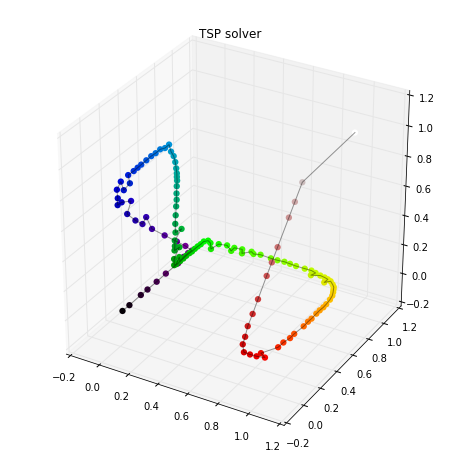

In [336]:
from mpl_toolkits.mplot3d import Axes3D
# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax.plot(*c.T, color='k', alpha=0.4)
ax.set_title('TSP solver')

plt.show()

Check below an interactive version of the 3D plot. May help when there are complicated paths between points. You need to install plotly and colorlover (with pip) if you don't already have them.

In [337]:
import plotly.graph_objs as go
import colorlover as cl
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

cb = cl.to_rgb(tuple(map(tuple, c*255)))
trace = go.Scatter3d(
        name='TSP Sover',
        x = c[:,0], y = c[:,1], z = c[:,2],
        marker = dict(
            size=4.,
            color=cb
        ),
        line=dict(
            color='#000',
            width=1,
        ),
        )
data = [trace]

# Set the different layout properties of the figure:
layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    margin = dict(
        t=0,b=0,l=0,r=0
    ),
    scene = go.Scene(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectmode='cube',
        camera=dict( 
            eye=dict(
                x=1.7,
                y=-1.7,
                z=1,
            )
        ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [277]:
from scipy.spatial import cKDTree
kdtree = cKDTree(c)

In [278]:
dx, ix = kdtree.query(im_)

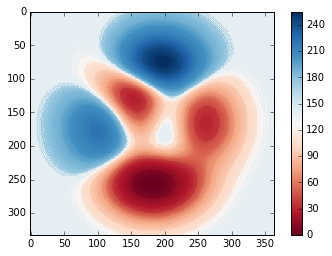

In [279]:
plt.imshow(ix.reshape((h, w)), cmap='RdBu')
plt.colorbar()
plt.show()

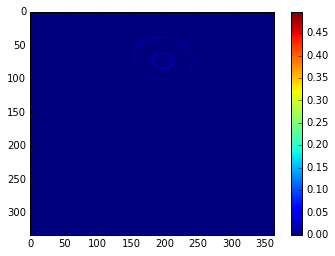

In [280]:
plt.imshow(dx.reshape((h, w)))
plt.colorbar()
plt.show()

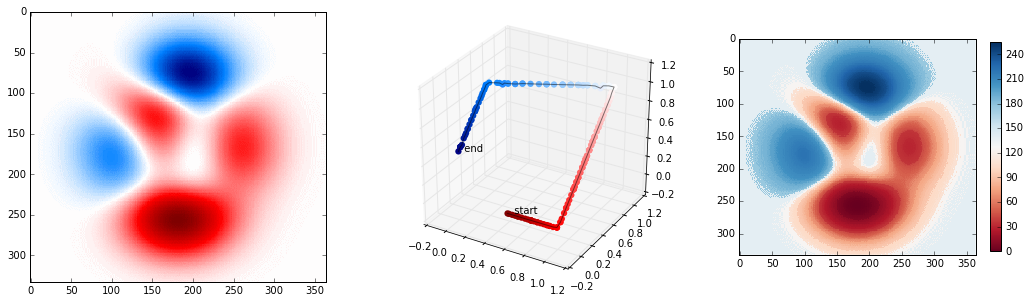

In [282]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im, interpolation='none')

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax1.plot(*c.T, color='k', alpha=0.5)
ax1.text(*c[0], '  start')
ax1.text(*c[-1], '  end')

ax2 = fig.add_subplot(133)
plt.imshow(ix.reshape((h, w)), cmap="RdBu", interpolation='none')
plt.colorbar(shrink=0.75)

plt.show()

In [137]:
cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]